# **Capstone Project GRP4 NLP B**

## <font color='green'>Steps and tasks:</font>

## <h3><font color='brown'>Pre-Processing, Data Visualizationand EDA </font><h3>

## <h4><font color='blue'>- Exploring the given Data files </font><h4>

In [28]:
# Imports

import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import plotly.graph_objects as go

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [29]:
tData = pd.read_excel('input_data.xlsx')  
tData.head(10)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


## <h4><font color='blue'>- Understanding the structure of data </font><h4>

In [30]:
#Shape of the data

tData.shape

(8500, 4)

In [31]:
# Data type of each attribute

tData.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

## <h4><font color='blue'>- Missing points in data </font><h4>

In [32]:
# Checking for missing values

x = tData.isna().sum()
print(x)

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64


In [33]:
# Check for duplicate data

dups = tData.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 83


In [34]:
# Removing duplicate data

tData.drop_duplicates(keep='first', inplace=True)
dups = tData.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [35]:
tData.shape

(8417, 4)

## <h4><font color='blue'>- Finding inconsistencies in the data </font><h4>

In [36]:
# Data Analysis based on Assignment Groups

targetClassCnt=tData['Assignment group'].value_counts()
targetClassCnt.describe()

count      74.000000
mean      113.743243
std       460.731077
min         1.000000
25%         5.250000
50%        26.000000
75%        81.000000
max      3934.000000
Name: Assignment group, dtype: float64

## <h4><font color='orange'>- Observations: </font><h4>
- Target class distrubtion is extremely skewed
- Large no of entries in 1 group (mounting to 3926) which is covering 50% of the data
- There are groups with single entry also. Those can be merged to a single group to reduce the imbalance to certain extend

In [37]:
# Regrouping

sample = tData.groupby(['Assignment group'])
regroup=[]
for grp in tData['Assignment group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
tData['Assignment group']=tData['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
tData['Assignment group'].unique()

Found 25 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

## <h4><font color='blue'>- Visualizing different patterns </font><h4>

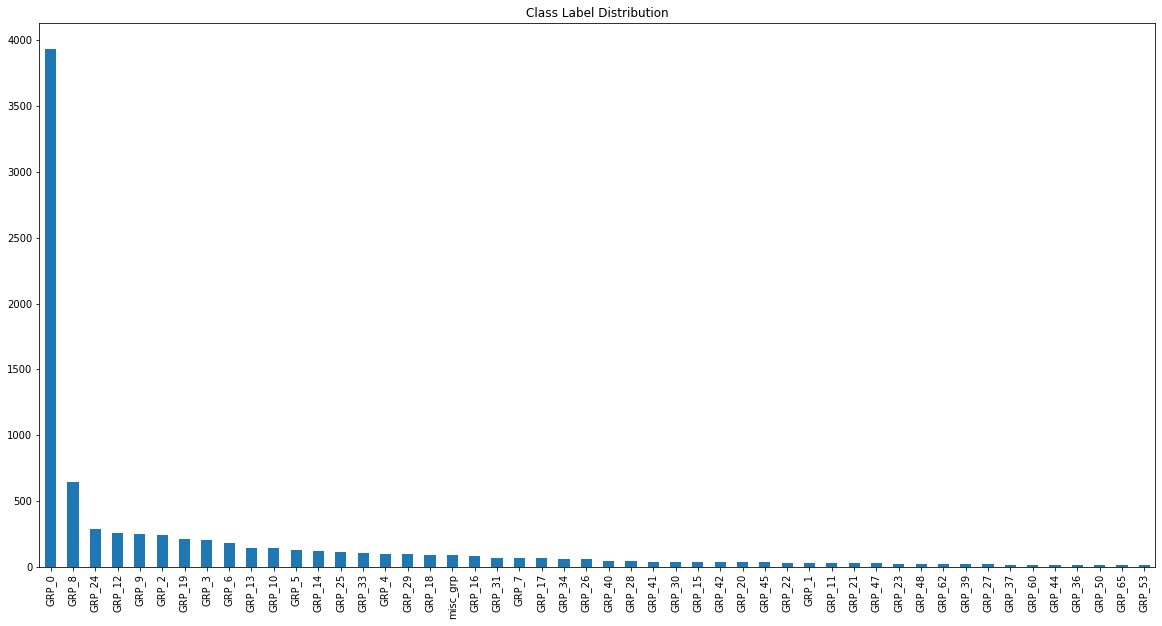

In [38]:
tData['Assignment group'].value_counts().plot(kind='bar', figsize=(20,10), title='Class Label Distribution')

## <h4><font color='blue'>- Visualizing different text features</font><h4>

In [39]:
# Word Clould of "Short descrition" Column

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

All_words = ""
All_words += " ".join(tData['Short description'])
wordcloud = WordCloud(background_color='white', include_numbers=True).generate(All_words) # width and height in the wordcloud attribute does not work
plt.figure(figsize=(15,15))
plt.title("WordCloud of Short description column", fontdict=font)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

TypeError: sequence item 2588: expected str instance, float found

In [40]:
# Word Clould of "Descrition" Column

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

All_words = ""
All_words += " ".join(tData['Description'])
wordcloud = WordCloud(background_color='white', include_numbers=True).generate(All_words) # width and height in the wordcloud attribute does not work
plt.figure(figsize=(15,15))
plt.title("WordCloud of Description column", fontdict=font)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

TypeError: sequence item 4361: expected str instance, float found

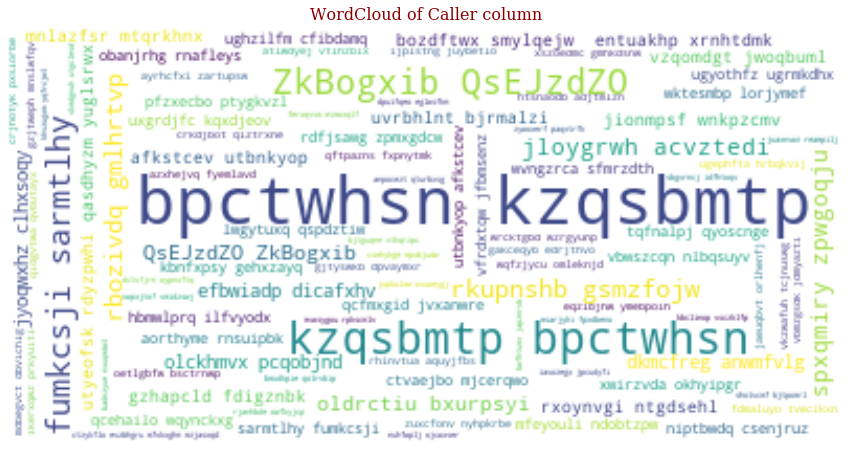

In [41]:
# Word Clould of "Caller" Column

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

All_words = ""
All_words += " ".join(tData['Caller'])
wordcloud = WordCloud(background_color='white', include_numbers=True).generate(All_words) # width and height in the wordcloud attribute does not work
plt.figure(figsize=(15,15))
plt.title("WordCloud of Caller column", fontdict=font)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [42]:
# Save the image in the img folder:

wordcloud.to_file("first_review.png")

## <h4><font color='blue'>- Dealing with missing values </font><h4>

In [43]:
# Removing Nans

tData.dropna(inplace = True)
tData.isna().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

## <h4><font color='blue'>- Text preprocessing </font><h4>

### Splitting the dataset based on frequency of the assignment group for analysis

In [44]:
#eliminate groups that have very less representation, that is we consider 95% significant data

group_elimination_treshold = 31

In [45]:
group_frequency_filtered = dict(filter(lambda x: x[1] >= group_elimination_treshold, group_frequency.items()))

In [46]:
print (group_frequency_filtered)

{'GRP_0': 3926, 'GRP_8': 645, 'GRP_24': 285, 'GRP_12': 257, 'GRP_9': 252, 'GRP_2': 241, 'GRP_19': 215, 'GRP_3': 200, 'GRP_6': 183, 'GRP_13': 145, 'GRP_10': 140, 'GRP_5': 128, 'GRP_14': 118, 'GRP_25': 116, 'GRP_33': 107, 'GRP_4': 100, 'GRP_29': 97, 'GRP_18': 88, 'misc_grp': 87, 'GRP_16': 85, 'GRP_31': 69, 'GRP_7': 68, 'GRP_17': 68, 'GRP_34': 61, 'GRP_26': 56, 'GRP_40': 45, 'GRP_28': 44, 'GRP_41': 40, 'GRP_30': 39, 'GRP_15': 38, 'GRP_42': 37, 'GRP_20': 36, 'GRP_45': 35, 'GRP_22': 31, 'GRP_1': 31}


In [48]:
#Lets now filter the data frame and retain only the necessary groups(Filtered)

valid_grp_list = list(group_frequency_filtered)

In [49]:
#eliminate

tData_filtered = tData[tData['Assignment group'].isin(valid_grp_list)]
tData_filtered.head(10)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


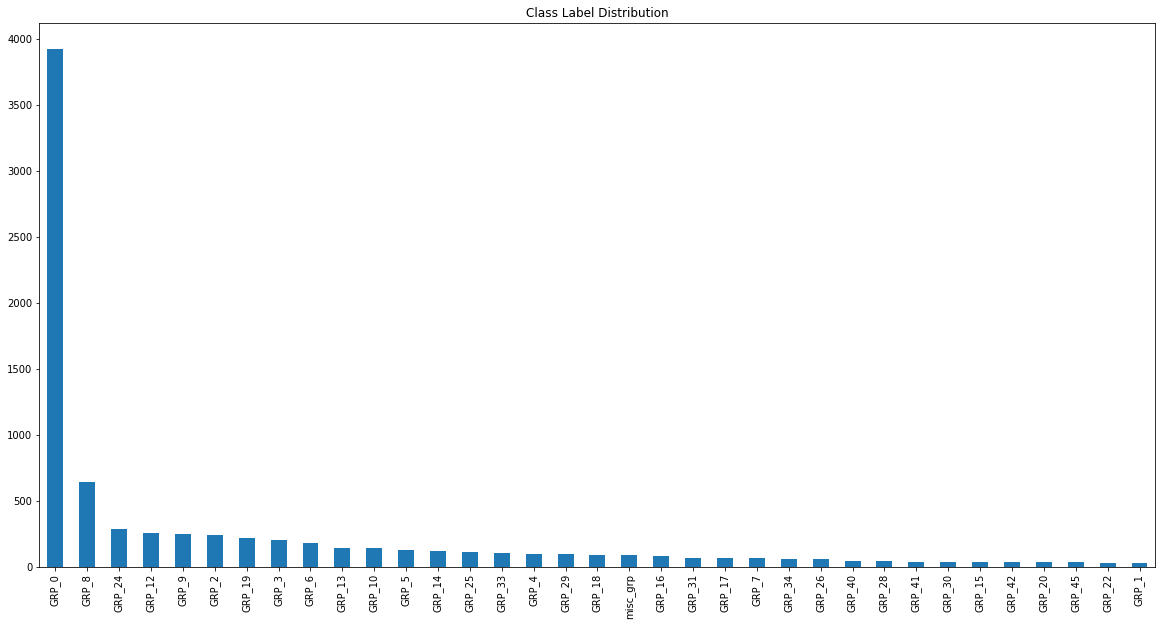

In [50]:
tData_filtered['Assignment group'].value_counts().plot(kind='bar', figsize=(20,10), title='Class Label Distribution')